In [1]:
import nltk
# nltk.download('punkt', download_dir='NLTK_DATA')
# nltk.download('stopwords', download_dir='NLTK_DATA')
nltk.data.path.append("NLTK_DATA")
import pandas as pd
import numpy as np
from processing import freqs, normalisasi
from sentiment import *

# PREPARASI _TRAINING DATASET_


In [2]:
# TODO: pindah ke sqlite
dataset = pd.read_csv("dataset/training_dataset.csv")
all_pos = dataset[dataset['label'] == 1]
all_neg = dataset[dataset['label'] == 0]

# ** Training data: 80% pertama
# ** Testing data: 20% terakhir
train_pos = all_pos[:int(len(all_pos)*0.8)]
train_neg = all_neg[:int(len(all_neg)*0.8)]
test_pos = all_pos[-int(len(all_pos)*0.2):]
test_neg = all_neg[-int(len(all_neg)*0.2):]

train_x = train_pos.append(train_neg, ignore_index=True)
test_x = test_pos.append(test_neg, ignore_index=True)

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

/tmp/ipykernel_1808969/400611212.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_x = train_pos.append(train_neg, ignore_index=True)
/tmp/ipykernel_1808969/400611212.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_x = test_pos.append(test_neg, ignore_index=True)


In [3]:
ld = len(dataset)
trp = len(train_pos)
tng = len(train_neg)
tsp = len(test_pos)
tsn = len(test_neg)
print(f"dataset: {ld} \n train pos: {trp} \n train neg: {tng} \n test pos: {tsp} \n test neg: {tsn}")

dataset: 1300 
 train pos: 511 
 train neg: 528 
 test pos: 127 
 test neg: 132


In [4]:
len(all_pos)

639

In [5]:
test_x

,text,label
0,Mending ngopi nyantai sambil dengar musik klas...,1
1,ada banyak fitur dari Kartu Perdana <PROVIDER...,1
2,Hari minggu masuk kerja tapi gak ada yang dike...,1
3,Sekarang enak belanja online. Sinyal kuat dan ...,1
4,Mantap! Paket <PRODUCT_NAME> dari <PROVIDER_NA...,1
...,...,...
254,Buried ini film budget termurah dengan tingkat...,0
255,"lalu setelah film berakhir, mikir ''ngapain no...",0
256,"Gila, film Britney Ever After jelek banget par...",0
257,Film danur nggak seperti novelnya. Harapan leb...,0


# PELATIHAN _MODEL CLASSIFIER_


In [6]:
x = train_x['text'].tolist()
y = train_y.tolist()
kamus_frek = kamus_freq(x, y)

In [ ]:
for x in kamus_frek.keys():
    print(kamus_frek.get(x, 0))

## logprior

$D$ = jumlah dokumen <br>
$D_{pos}$ = jumlah dokumen positif <br>
$D_{neg}$ = jumlah dokumen negatif <br>

### probabilitas dokumen positif

$P(D_{pos}) = \frac{D_{pos}}{D}$

### probabilitas dokumen negatif

$P(D_{neg}) = \frac{D_{neg}}{D}$

### probabilitas prior

${logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$
<br> disederhanakan, menjadi: <br>
$logprior = P(D_{pos}) - P(D_{neg})$


## loglikelihood

$W$ = probabilitas positif/negatif kata <br>
$freq$ = frekuensi kata unik yang bernilai positif/negatif <br>
$N$ = jumlah total kata positif/negatif <br>
$V$ = jumlah total kata unik (panjang dokumen frekuensi) <br>

### probabilitas kata positif

$P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}$

### probabilitas kata negatif

$P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}$

### likelihood kata

$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)$


In [7]:
# logprior, loglikelihood = train_nbc(kamus_frek, train_y)
logprior = hitungPrior(kamus_frek, train_y)
loglikelihood = hitungLikelihood(kamus_frek)
# print(logprior)
# print(loglikelihood)

In [7]:
from sentiment import predict_nbc
predict_nbc("bagussss", logprior, loglikelihood)

0.6604204870573883

## HASIL PENGUJIAN MODEL

-   data _training_
-   data _testing_


In [13]:
test = test_nbc(test_x['text'].tolist(), test_y.tolist(), logprior, loglikelihood)
test

'84.56%'

## _CONFUSION MATRIX_


## metrik-metrik

-   TP = True Positive
-   TN = True Negative
-   FP = False Positive
-   FN = False Negative
-   Populasi = TP+TN+FP+FN
<hr>

### akurasi

jumlah prediksi yang benar. tidak dianjurkan sebagai metrik kunci. <br>
$\frac{TP+TN}{Populasi}$

### miss

jumlah prediksi yang salah <br>
$\frac{FP+FN}{Populasi}$

### presisi

persentase positif yang diprediksi secara akurat. jika FP = 0, maka nilai presisi 100%. <br>
$\frac{TP}{TP+FP}$

### sensitifitas

nilai positif sesungguhnya <br>
$\frac{TP}{TP+FN}$


In [8]:
pdc = pd.DataFrame()
pdc = test_x
pdc['label_prediksi'] = pdc['text'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

In [9]:
# TODO: Do more testing with thresholds values from 0, 0.5, 0.8, 0.9, 1
# * to note;
# treshold = -0.03272669350255697
# * default treshold is 0
def toLabel(x):
   if x > 0:
       return 1
   elif x < 0:
       return 0
   else:
       return "n"
pdc['prediksi'] = pdc['label_prediksi'].apply(lambda x: toLabel(x))

In [10]:
pdc

,text,label,label_prediksi,prediksi
0,Mending ngopi nyantai sambil dengar musik klas...,1,5.739512,1
1,ada banyak fitur dari Kartu Perdana <PROVIDER...,1,-5.238374,0
2,Hari minggu masuk kerja tapi gak ada yang dike...,1,-0.864432,0
3,Sekarang enak belanja online. Sinyal kuat dan ...,1,-1.381235,0
4,Mantap! Paket <PRODUCT_NAME> dari <PROVIDER_NA...,1,3.384933,1
...,...,...,...,...
254,Buried ini film budget termurah dengan tingkat...,0,-0.119738,0
255,"lalu setelah film berakhir, mikir ''ngapain no...",0,-4.292054,0
256,"Gila, film Britney Ever After jelek banget par...",0,-5.034438,0
257,Film danur nggak seperti novelnya. Harapan leb...,0,-6.098780,0


In [11]:
conf_matrix = pd.crosstab(pdc['label'], pdc['prediksi'], rownames=['Actual'], colnames=['Predicted'])
conf_matrix

Predicted,0,1
Actual,,
0,123,9
1,49,78


In [12]:
tn = 123
fn = 49
tp = 78
fp = 9
pop = tn+tp+fn+fp
a = (tn+tp)/pop
m = (fp+fn)/pop
p = tp/(tp+fp)
s = tp/(tp+fn)
print(f"pop={pop}\nakurasi:{a}, miss:{m}, presisi: {p}, sensi: {s}.\n F1:{2*(p*s)/(p+s)}")

pop=259
akurasi:0.7760617760617761, miss:0.22393822393822393, presisi: 0.896551724137931, sensi: 0.6141732283464567.
 F1:0.7289719626168225


In [ ]:
pdc

Matplotlib is building the font cache; this may take a moment.


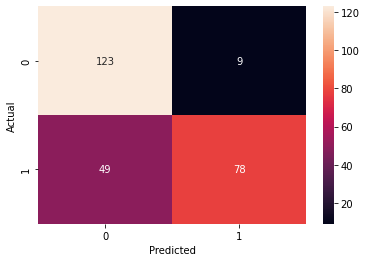

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()

# UJI CLASSIFIER PADA ARTIKEL BERITA


In [ ]:
berita = open('berita.txt', 'r')
berita = berita.read()

In [ ]:
beritanormal = normalisasi(berita)
frekberita = freqs(beritanormal)
# frekberita

## SENTIMEN ARTIKEL KESELURUHAN


In [ ]:
predict_nbc(berita, logprior, loglikelihood)

## SENTIMEN ARTIKEL PER_KALIMAT


In [ ]:
from nltk.tokenize import sent_tokenize
x = pd.DataFrame()
kalimat = sent_tokenize(berita)
x['kalimat'] = kalimat
x['kalimat_normal'] = x['kalimat'].apply(lambda x: normalisasi(x))

In [ ]:
x['label_prediksi'] = x['kalimat'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

In [ ]:
x['prediksi'] = x['label_prediksi'].apply(lambda x: toLabel(x))
x

## SENTIMEN ARTIKEL PER_KATA


In [ ]:
berita_normal = normalisasi(berita)

In [ ]:
# * predict_nbc per-kata
def predict_perkata(text, logpri, loglik):
    l = []
    for w in text:
        x = predict_nbc(w, logpri, loglik)
        l.append({
            "kata":w,
            "skor":x
            })
    return l

In [ ]:
hasil = predict_perkata(berita_normal, logprior, loglikelihood)
type(hasil[0])

In [ ]:
hasil

In [ ]:
logprior

In [ ]:
import csv
keys = hasil[0].keys()

with open('demo-kata.csv', 'w', newline='') as file:
    dict_writer = csv.DictWriter(file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(hasil)